# block-internals

> An experiment to examine the internals of a self-attention block


In [ ]:
#| default_exp experiments.block_internals

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from fastcore.test import *

In [ ]:
#| export
from collections import defaultdict, OrderedDict
from dataclasses import dataclass
import json
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile
from typing import Callable, Dict, Iterable, Iterator, List, Optional, Protocol, Sequence, Tuple

In [ ]:
#| export
import click
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

In [ ]:
#| export
from transformer_experiments.common.databatcher import DataBatcher
from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.utils import topk_across_batches
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.tokenizers.char_tokenizer import CharacterTokenizer
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
)


In [ ]:
#| export

class BlockInternalsAccessors:
    """Helper class that provides easy access to the block internals values
    for a given prompt."""
    def __init__(self, prompt: str, eh: EncodingHelpers, accessors: TransformerAccessors):
        self.prompt = prompt
        self.eh = eh
        self.accessors = accessors

        tokens = self.eh.tokenize_string(prompt)
        self.embedding = accessors.embed_tokens(tokens)

        _, self.io_accessors = accessors.run_model(self.embedding)

    def input_embedding(self) -> torch.Tensor:
        """Returns the input to the specified block."""
        return self.embedding

    def block_input(self, block_idx: int) -> torch.Tensor:
        """Returns the input to the specified block."""
        return self.io_accessors[block_idx].input('.')

    def heads_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the attention heads in the specified block."""
        # Heads output is the input to the self-attention proj layer.
        return self.io_accessors[block_idx].input('sa.proj')

    def proj_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the self-attention proj layer in the specified block."""
        return self.io_accessors[block_idx].output('sa.proj')

    def ffwd_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the feed-forward layer in the specified block."""
        return self.io_accessors[block_idx].output('ffwd')

    def block_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the specified block."""
        return self.io_accessors[block_idx].output('.')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device is {device}")

device is cpu


In [ ]:
ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
# Tests for BlockInternalsAccessors
prompt = 'ROMEO:'
b = BlockInternalsAccessors(
    prompt=prompt,
    eh=encoding_helpers,
    accessors=accessors,
)

# Test shapes of all the things.
test_eq(b.input_embedding().shape, (1, len(prompt), n_embed))
for block_idx in range(n_layer):
    test_eq(b.block_input(block_idx).shape, (1, len(prompt), n_embed))
    test_eq(b.heads_output(block_idx).shape, (1, len(prompt), n_embed))
    test_eq(b.proj_output(block_idx).shape, (1, len(prompt), n_embed))
    test_eq(b.ffwd_output(block_idx).shape, (1, len(prompt), n_embed))
    test_eq(b.block_output(block_idx).shape, (1, len(prompt), n_embed))

# Logits produced by the model should be the same as the logits produced by
# the output of the last block.
logits, _ = m(encoding_helpers.tokenize_string(prompt))
test_close(logits, accessors.logits_from_embedding(b.block_output(n_layer-1)))

In [ ]:
# | export
class BlockInternalsExperiment:
    """An experiment to run a bunch of inputs through the model and save the
    intermediate values produced within each block."""
    def __init__(
        self,
        eh: EncodingHelpers,
        accessors: TransformerAccessors,
        strings: Sequence[str],
    ):
        self.eh = eh
        self.accessors = accessors
        self.strings = strings

        tokens = self.eh.tokenize_strings(self.strings)
        self.embeddings = self.accessors.embed_tokens(tokens)

        # Create a map of string to index to enable fast lookup.
        self.idx_map = OrderedDict((s, idx) for idx, s in enumerate(self.strings))

        # Run the embeddings through the model.
        _, self.io_accessors = self.accessors.run_model(self.embeddings)

    def string_idx(self, s: str) -> int:
        """Returns the index of the specified string."""
        return self.idx_map[s]

    def block_input(self, block_idx: int) -> torch.Tensor:
        """Returns the input to the specified block."""
        return self.io_accessors[block_idx].input('.')

    def heads_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the attention heads in the specified block."""
        # Heads output is the input to the self-attention proj layer.
        return self.io_accessors[block_idx].input('sa.proj')

    def proj_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the self-attention proj layer in the specified block."""
        return self.io_accessors[block_idx].output('sa.proj')

    def ffwd_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the feed-forward layer in the specified block."""
        return self.io_accessors[block_idx].output('ffwd')

    def block_output(self, block_idx: int) -> torch.Tensor:
        """Returns the output of the specified block."""
        return self.io_accessors[block_idx].output('.')


In [ ]:
# Test for BlockInternalsExperiment
s_len = 3
strings = all_unique_substrings(ts.text[:100], s_len)
experiment = BlockInternalsExperiment(encoding_helpers, accessors, strings)

# Test the string_idx() method
for i, s in enumerate(strings):
    test_eq(experiment.string_idx(s), i)

# Check that all the accessors return tensors of the expected shape.
for block_idx in range(n_layer):
    test_eq(experiment.block_input(block_idx).shape, (len(strings), s_len, n_embed))
    test_eq(experiment.heads_output(block_idx).shape, (len(strings), s_len, n_embed))
    test_eq(experiment.proj_output(block_idx).shape, (len(strings), s_len, n_embed))
    test_eq(experiment.ffwd_output(block_idx).shape, (len(strings), s_len, n_embed))
    test_eq(experiment.block_output(block_idx).shape, (len(strings), s_len, n_embed))

# Run the strings through the model directly.
tokens = encoding_helpers.tokenize_strings(strings)
logits, _ = m(tokens)

# Logits generated from the last block output in the experiment should
# be the same as the logits produced by running the model directly.
last_block_output = experiment.block_output(n_layer - 1)
test_close(accessors.logits_from_embedding(last_block_output), logits)

In [ ]:
#| export
class DistanceFunction(Protocol):
    """A protocol for a function that computes distances between a batch
    of data and a set of queries."""
    def __call__(self, batch: torch.Tensor, queries: torch.Tensor) -> torch.Tensor:
        ...

In [ ]:
# | export
def batch_distances(batch: torch.Tensor, queries: torch.Tensor) -> torch.Tensor:
    """Returns the distance between each item in the batch and the queries."""
    assert batch.dim() == 2, f"batch.dim() should be 2, was {batch.dim()}"
    assert queries.dim() == 2, f"query.dim() should be 2, was {queries.dim()}"
    assert (
        batch.shape[-1] == queries.shape[-1]
    ), f"last dimension of batch was {batch.shape[-1]}, which does not match last dimension of queries {queries.shape[-1]}"

    B, _ = batch.shape
    n_queries, _ = queries.shape

    distances = torch.norm(
        # Reshape the batch to a singleton dimension, then expand that dimension
        # by the number of queries. We can then subtract all the queries in one
        # go.
        batch.reshape(B, 1, -1).expand(-1, n_queries, -1) - queries,
        dim=2
    )
    return distances


In [ ]:
# | export
def batch_cosine_sim(batch: torch.Tensor, queries: torch.Tensor) -> torch.Tensor:
    """Returns the cosine similarity between each item in the batch and the queries."""
    assert batch.dim() == 2, f"batch.dim() should be 2, was {batch.dim()}"
    assert queries.dim() == 2, f"query.dim() should be 2, was {queries.dim()}"
    assert (
        batch.shape[-1] == queries.shape[-1]
    ), f"last dimension of batch was {batch.shape[-1]}, which does not match last dimension of queries {queries.shape[-1]}"

    B, _ = batch.shape
    n_queries, _ = queries.shape
    return F.cosine_similarity(batch.reshape(B, 1, -1).expand(-1, n_queries, -1), queries, dim=-1)

In [ ]:
#| export
class GetFilenameForBatchAndBlock(Protocol):
    """A protocol for a function that returns a filename for given batch
    and block indices."""
    def __call__(self, batch_idx: int, block_idx: int) -> Path:
        ...

In [ ]:
# | export
class BatchedBlockInternalsExperiment:
    """Similar to BlockInternalsExperiment but rather than running
    all strings as one batch through the model, this one runs them
    in batches and writes results to disk. This makes it possible to
    run the analysis on longer strings."""

    def __init__(
        self,
        eh: EncodingHelpers,
        accessors: TransformerAccessors,
        strings: Sequence[str],
        output_dir: Path,
        batch_size: int = 10000,
    ):
        self.eh = eh
        self.accessors = accessors
        self.strings = strings
        self.output_dir = output_dir
        self.batch_size = batch_size

        # Create a map of string to index to enable fast lookup.
        self.idx_map = OrderedDict((s, idx) for idx, s in enumerate(self.strings))

        self.n_batches = math.ceil(len(self.strings) / self.batch_size)

    def sample_length(self) -> int:
        return len(self.strings[0])

    def run(self, disable_progress_bars: bool = False):
        for batch_idx in tqdm(range(self.n_batches), disable=disable_progress_bars):
            start_idx = batch_idx * self.batch_size
            end_idx = start_idx + self.batch_size
            batch_strings = self.strings[start_idx:end_idx]
            self._run_batch(batch_idx, batch_strings)

    def _embeddings_filename(self, batch_idx: int) -> Path:
        return self.output_dir / f'embeddings-{batch_idx:03d}.pt'

    def _block_input_filename(self, batch_idx: int, block_idx: int) -> Path:
        return self.output_dir / f'block_input-{batch_idx:03d}-{block_idx:02d}.pt'

    def _heads_output_filename(self, batch_idx: int, block_idx: int) -> Path:
        return self.output_dir / f'heads_output-{batch_idx:03d}-{block_idx:02d}.pt'

    def _proj_output_filename(self, batch_idx: int, block_idx: int) -> Path:
        return self.output_dir / f'proj_output-{batch_idx:03d}-{block_idx:02d}.pt'

    def _ffwd_output_filename(self, batch_idx: int, block_idx: int) -> Path:
        return self.output_dir / f'ffwd_output-{batch_idx:03d}-{block_idx:02d}.pt'

    def _block_output_filename(self, batch_idx: int, block_idx: int) -> Path:
        return self.output_dir / f'block_output-{batch_idx:03d}-{block_idx:02d}.pt'

    def _run_batch(self, batch_idx: int, batch_strings: Sequence[str]):
        tokens = self.eh.tokenize_strings(batch_strings)
        embeddings = self.accessors.embed_tokens(tokens)

        torch.save(embeddings, self._embeddings_filename(batch_idx))

        # Run the embeddings through the model.
        _, io_accessors = self.accessors.run_model(embeddings)

        # Write the results to disk.
        for block_idx, io_accessor in enumerate(io_accessors):
            torch.save(
                io_accessor.input('.'),
                self._block_input_filename(batch_idx, block_idx),
            )
            torch.save(
                io_accessor.input('sa.proj'),
                self._heads_output_filename(batch_idx, block_idx),
            )
            torch.save(
                io_accessor.output('sa.proj'),
                self._proj_output_filename(batch_idx, block_idx),
            )
            torch.save(
                io_accessor.output('ffwd'),
                self._ffwd_output_filename(batch_idx, block_idx),
            )
            torch.save(
                io_accessor.output('.'),
                self._block_output_filename(batch_idx, block_idx),
            )

    def string_idx(self, s: str) -> int:
        """Returns the index of the specified string."""
        return self.idx_map[s]

    def strings_from_indices(
        self, indices: torch.Tensor, alt_all_strings: Sequence[str] = []
    ) -> List[List[str]]:
        """Returns the strings corresponding to the specified indices.
        Indices is expected to be of shape (k, n). The returned list
        will have n elements, each of which is a list of k strings."""
        _, n = indices.shape

        all_strings = self.strings

        if len(alt_all_strings) > 0:
            all_strings = alt_all_strings

        # We're going to return a list of lists of strings. The
        # string at index [i][j] in the returned list is the
        # string corresponding to indices[j, i].
        strings: List[List[str]] = [[] for _ in range(n)]

        for ind in indices:
            for i, idx in enumerate(ind):
                strings[i].append(all_strings[idx])

        return strings

    def strings_with_topk_closest_embeddings(
        self,
        queries: torch.Tensor,
        k: int,
        largest: bool = False,
        distance_function: DistanceFunction = batch_distances,
    ) -> Tuple[Sequence[Sequence[str]], torch.Tensor]:
        """Returns the top k strings with the closest embeddings
        to the specified query."""

        n_queries, _, _ = queries.shape

        def _process_batch(batch: torch.Tensor) -> torch.Tensor:
            B, _, _ = batch.shape
            # Batch and queries and both shape (B, s_len, n_embed).
            # For the purposes of finding the closest values, we
            # reshape both the batch and queries to eliminate the
            # s_len dimension, effectively concatenating all the
            # embedding tensors across positions.
            return distance_function(batch.reshape(B, -1), queries.reshape(n_queries, -1))

        values, indices = topk_across_batches(
            n_batches=self.n_batches,
            k=k,
            largest=largest,
            load_batch=lambda i: torch.load(
                str(self._embeddings_filename(i)), mmap=True
            ),
            process_batch=_process_batch,
        )

        return self.strings_from_indices(indices), values

    def _convert_t_i(self, t_i: int) -> int:
        """Converts a negative t_i to a positive one."""
        if t_i < 0:
            t_i = self.sample_length() + t_i

        assert t_i >= 0, f"converted t_i must be >= 0, was {t_i}"
        return t_i

    def _unique_substring_map(self, t_i: int) -> OrderedDict[str, int]:
        """Returns a map of unique substrings to indices."""
        t_i = self._convert_t_i(t_i)
        assert (
            t_i < self.sample_length() - 1
        ), f"t_i must be less than {self.sample_length() - 1} to generate unique substring map, was {t_i}"

        od = OrderedDict()
        # Insert substrings in order of first appearance.
        for i, s in enumerate(self.strings):
            substring = s[: t_i + 1]
            if substring not in od:
                od[substring] = i
        return od

    def _strings_with_topk_closest_outputs(
        self,
        get_filename: GetFilenameForBatchAndBlock,
        block_idx: int,
        t_i: int,
        queries: torch.Tensor,
        k: int,
        largest: bool = False,
        distance_function: DistanceFunction = batch_distances,
    ) -> Tuple[Sequence[Sequence[str]], torch.Tensor]:
        """Returns the top k strings with the closest outputs
        to the specified query, using the given `get_filename`
        function to load batches of the output data."""

        t_i = self._convert_t_i(t_i)

        all_strings = self.strings
        unique_substring_indices: Optional[torch.Tensor] = None

        # If the requested t_i is not the last character, we
        # need to compute the unique substrings of length t_i + 1.
        # We'll only evaluate outputs for these unique substrings.
        if t_i < self.sample_length() - 1:
            unique_substring_map = self._unique_substring_map(t_i)
            all_strings = list(unique_substring_map.keys())

            # The keys of the ordered dictionary are the indices into
            # self.strings i.e. the global indices of the unique substrings.
            unique_substring_indices = torch.tensor(list(unique_substring_map.values()))

        def _load_batch(batch_idx: int) -> torch.Tensor:
            if t_i == self.sample_length() - 1:
                # If we're looking at the last character, we can just
                # load the batch and index it directly.
                return torch.load(
                    str(
                        get_filename(
                            batch_idx=batch_idx, block_idx=block_idx
                        )
                    ),
                    mmap=True,
                )[:, t_i, :]

            # Otherwise, we need to find just the unique substrings that
            # appear in the batch and return the subset of the batch
            # containing them.
            assert unique_substring_indices is not None

            # Find the indices of the unique substrings that appear
            # in the batch we're asked to load.
            mask = (unique_substring_indices >= batch_idx * self.batch_size) & (
                unique_substring_indices < (batch_idx + 1) * self.batch_size
            )
            batch_indices = (
                unique_substring_indices[torch.nonzero(mask).squeeze(dim=1)]
                - batch_idx * self.batch_size
            )
            assert (
                batch_indices.shape[0] > 0
            ), f"batch_indices were empty for batch_idx {batch_idx}"

            return torch.load(
                str(
                    get_filename(batch_idx=batch_idx, block_idx=block_idx)
                ),
                mmap=True,
            )[batch_indices, t_i, :]

        def _process_batch(batch: torch.Tensor) -> torch.Tensor:
            return distance_function(batch, queries=queries)

        values, indices = topk_across_batches(
            n_batches=self.n_batches,
            k=k,
            largest=largest,
            load_batch=_load_batch,
            process_batch=_process_batch,
        )
        return self.strings_from_indices(indices, alt_all_strings=all_strings), values

    def strings_with_topk_closest_proj_outputs(
        self,
        block_idx: int,
        t_i: int,
        queries: torch.Tensor,
        k: int,
        largest: bool = False,
        distance_function: DistanceFunction = batch_distances,
    ) -> Tuple[Sequence[Sequence[str]], torch.Tensor]:
        """Returns the top k strings with the closest proj outputs
        to the specified query."""
        return self._strings_with_topk_closest_outputs(
            get_filename=self._proj_output_filename,
            block_idx=block_idx,
            t_i=t_i,
            queries=queries,
            k=k,
            largest=largest,
            distance_function=distance_function,
        )

    def strings_with_topk_closest_ffwd_outputs(
        self,
        block_idx: int,
        t_i: int,
        queries: torch.Tensor,
        k: int,
        largest: bool = False,
        distance_function: DistanceFunction = batch_distances,
    ) -> Tuple[Sequence[Sequence[str]], torch.Tensor]:
        """Returns the top k strings with the closest ffwd outputs
        to the specified query."""

        return self._strings_with_topk_closest_outputs(
            get_filename=self._ffwd_output_filename,
            block_idx=block_idx,
            t_i=t_i,
            queries=queries,
            k=k,
            largest=largest,
            distance_function=distance_function,
        )

In [ ]:
# Test for BatchedBlockInternalsExperiment
s_len = 3
strings = all_unique_substrings(ts.text[:100], s_len)

with tempfile.TemporaryDirectory() as tmpdirname:
    experiment = BatchedBlockInternalsExperiment(
        encoding_helpers, accessors, strings, output_dir=Path(tmpdirname), batch_size=10
    )
    test_eq(experiment.sample_length(), s_len)
    experiment.run(disable_progress_bars=True)

    # Test the string_idx() method
    for i, s in enumerate(strings):
        test_eq(experiment.string_idx(s), i)

    prompts = [strings[i] for i in [10, 17, 1]] # indices are arbitrary
    test_eq(prompts, ['zen', 'for', 'irs']) # ensure that something will fail if we change indices above

    prompt_exp = BlockInternalsExperiment(encoding_helpers, accessors, prompts)

    # Test closest embeddings
    sim_strings, distances = experiment.strings_with_topk_closest_embeddings(
        queries=prompt_exp.embeddings,
        k=3,
        largest=False
    )
    test_eq(sim_strings, [ # compare against known correct results
        ['zen', 'we ', 'her'],
        ['for', 'fur', 'Fir'],
        ['irs', 'ar ', 'urt']
    ])
    test_close(distances, torch.tensor([ # compare against known correct results
        [0.0000, 0.0000, 0.0000],
        [1.4657, 1.0683, 1.4207],
        [1.4741, 1.2944, 1.4239]
    ]), eps=1e-4)

    # Test closest proj outputs
    block_idx = 0
    t_i = -1
    sim_strings, distances = experiment.strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        t_i=t_i,
        queries=prompt_exp.proj_output(block_idx)[:, t_i, :],
        k=3,
        largest=False,
    )
    test_eq(
        sim_strings,
        [
            # fmt: off
            ['zen', 'ize', 'we '],
            ['for', 'roc', 'efo'],
            ['irs', 'urt', 'pro'],
            # fmt: on
        ],
    )
    test_close(
        distances,
        torch.tensor(
            [  # compare against known correct results
                # fmt: off
                [0.0000, 0.0000, 0.0000],
                [1.4794, 1.2580, 1.3404],
                [1.4864, 1.4445, 1.3449],
                # fmt: on
            ]
        ),
        eps=1e-4,
    )

    # Test closest ffwd outputs
    block_idx = 4
    t_i = -1
    sim_strings, distances = experiment.strings_with_topk_closest_ffwd_outputs(
        block_idx=block_idx,
        t_i=t_i,
        queries=prompt_exp.ffwd_output(block_idx)[:, t_i, :],
        k=3,
        largest=False,
    )
    test_eq(
        sim_strings,
        [
            # fmt: off
            ['zen', 'eak', 'the'],
            ['for', ' me', 'zen'],
            ['irs', 'urt', 'eak'],
            # fmt: on
        ],
    )
    test_close(
        distances,
        torch.tensor(
            [  # compare against known correct results
                # fmt: off
                [0.0000, 0.0000, 0.0000],
                [3.4993, 3.7176, 4.8893],
                [3.5395, 3.7680, 4.9150],
                # fmt: on
            ]
        ),
        eps=1e-4,
    )

    # Test closest proj outputs with a non-final t_i
    block_idx = 2
    t_i = 1
    sim_strings, distances = experiment.strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        t_i=t_i,
        queries=prompt_exp.proj_output(block_idx)[:, t_i, :],
        k=3,
        largest=False,
    )

    # Test that all strings have length t_i + 1
    for i in range(3):
        for j in range(len(prompts)):
            test_eq(len(sim_strings[i][j]), t_i + 1)
    test_eq(
        sim_strings,
        [
            # fmt: off
            ['ze', 'rt', 'iz'],
            ['fo', 'fu', ' f'],
            ['ir', 'iz', 'it'],
            # fmt: on
        ],
    )
    test_close(
        distances,
        torch.tensor(
            [  # compare against known correct results
                # fmt: off
                [0.0000, 0.0000, 0.0000],
                [2.0715, 0.9072, 0.9928],
                [2.1107, 1.6824, 1.0663],
                # fmt: on
            ]
        ),
        eps=1e-4,
    )

    # Test closest ffwd outputs with a non-final t_i
    block_idx = 5
    t_i = 1
    sim_strings, distances = experiment.strings_with_topk_closest_ffwd_outputs(
        block_idx=block_idx,
        t_i=t_i,
        queries=prompt_exp.ffwd_output(block_idx)[:, t_i, :],
        k=3,
        largest=False,
    )

    # Test that all strings have length t_i + 1
    for i in range(3):
        for j in range(len(prompts)):
            test_eq(len(sim_strings[i][j]), t_i + 1)
    test_eq(
        sim_strings,
        [
            # fmt: off
            ['ze', 'ce', 'we'],
            ['fo', 'ti', 'st'],
            ['ir', 'ar', 'ur'],
            # fmt: on
        ],
    )
    test_close(
        distances,
        torch.tensor(
            [  # compare against known correct results
                # fmt: off
                [0.0000, 0.0000, 0.0000],
                [1.9583, 3.3032, 2.0351],
                [2.0340, 3.3642, 2.2757],
                # fmt: on
            ]
        ),
        eps=1e-4,
    )


In [ ]:
#| export
@click.command()
@click.argument("model_weights_filename", type=click.Path(exists=True))
@click.argument("dataset_cache_filename", type=click.Path(exists=True))
@click.argument("output_folder", type=click.Path(exists=True))
@click.option(
    "-s",
    "--sample_len",
    required=True,
    type=click.IntRange(min=1, max=block_size),
)
@click.option(
    "-m",
    "--max_batch_size",
    required=False,
    type=click.IntRange(min=1),
    default=10000,
)
def run(
    model_weights_filename: str,
    dataset_cache_filename: str,
    output_folder: str,
    sample_len: int,
    max_batch_size: int,
):
    click.echo(f"Running block internals experiment for with:")
    click.echo(f"  model weights: {model_weights_filename}")
    click.echo(f"  dataset cache: {dataset_cache_filename}")
    click.echo(f"  output folder: {output_folder}")
    click.echo(f"  sample length: {sample_len}")
    click.echo(f"  max batch size: {max_batch_size}")

    # Instantiate the model, tokenizer, and dataset
    device = "cuda" if torch.cuda.is_available() else "cpu"
    click.echo(f"device is {device}")

    ts = TinyShakespeareDataSet(cache_file=dataset_cache_filename)
    m, tokenizer = create_model_and_tokenizer(
        saved_model_filename=model_weights_filename,
        dataset=ts,
        device=device,
    )

    strings = all_unique_substrings(ts.text, sample_len)

    encoding_helpers = EncodingHelpers(tokenizer, device)
    accessors = TransformerAccessors(m, device)

    # Create the experiment
    exp = BatchedBlockInternalsExperiment(
        encoding_helpers, accessors, strings, Path(output_folder), max_batch_size
    )

    exp.run()

In [ ]:
# | export
class BlockInternalsAnalysis:
    """This class performs analysis of how the next token probabilities change
    as an embedded input is passed through each of the blocks in the model"""

    def __init__(
        self,
        accessors: TransformerAccessors,
        encoding_helpers: EncodingHelpers,
        prompt: str,
    ):
        self.accessors = accessors
        self.encoding_helpers = encoding_helpers
        self.prompt = prompt

        # Run the prompt through the model
        tokens = self.encoding_helpers.tokenize_string(prompt)
        x = self.accessors.embed_tokens(tokens)
        _, io_accessors = self.accessors.run_model(x)

        tokenizer = self.encoding_helpers.tokenizer

        # The data tensor is going to be a stack of probabilities. Columns
        # correspond to tokens.
        #
        # Row index 0 is the probabilities from the input embedding.
        # Row index 1 + 2 * block_idx is the probabilities that result from
        #   adding block block_idx's self-attention output to its input.
        # Row index 1 + 2 * block_idx + 1 is the probabilities that result from
        #   adding block block_idx's feed-forward output to the previous result.
        #
        # Examples:
        #   self.data[0][tokenizer.stoi['a']] is the probability of the next
        #       token being 'a' given the input embedding.
        #   self.data[1][tokenizer.stoi['a']] is the probability of the next
        #       token being 'a' given the input embedding plus the self-attention
        #       output of the first block.
        #   self.data[2][tokenizer.stoi['a']] is the probability of the next
        #       token being 'a' given the input embedding plus the self-attention
        #       output of the first block plus the feed-forward output of the
        #       first block.
        #   self.data[3][tokenizer.stoi['a']] is the probability of the next
        #       token being 'a' given the output of the first block plus the
        #       self-attention output of the second block.
        self.data = torch.zeros(
            (1 + 2 * n_layer, tokenizer.vocab_size), dtype=torch.float32
        )
        self.data[0] = LogitsWrapper(
            self.accessors.logits_from_embedding(x), tokenizer
        ).probs()[0, -1]
        self.row_labels = ['Input']
        for block_idx, io_accessor in enumerate(io_accessors):
            block_input = io_accessor.input('.')
            sa_output = io_accessor.output('sa')
            ffwd_output = io_accessor.output('ffwd')

            # The logic inside a block is:
            #   x = x + self.sa(self.ln1(x))
            #   x = x + self.ffwd(self.ln2(x))
            #
            # sa_adjusted_logits simulates the first line
            # and ffwd_adjusted_logits simulates the second line.

            sa_adjusted_logits = LogitsWrapper(
                self.accessors.logits_from_embedding(block_input + sa_output), tokenizer
            )
            self.data[self.idx_sa_probs(block_idx)] = sa_adjusted_logits.probs()[0, -1]
            self.row_labels.append(f'Block {block_idx} after SA')

            ffwd_adjusted_logits = LogitsWrapper(
                self.accessors.logits_from_embedding(
                    block_input + sa_output + ffwd_output
                ),
                tokenizer,
            )
            self.data[self.idx_ffwd_probs(block_idx)] = ffwd_adjusted_logits.probs()[
                0, -1
            ]
            self.row_labels.append(f'Block {block_idx} after FFWD')

    def idx_sa_probs(self, block_idx: int) -> int:
        """Returns the index into the data tensor containing the SA adjusted
        probabilities for the given block index."""
        return 1 + 2 * block_idx

    def idx_ffwd_probs(self, block_idx: int) -> int:
        """Returns the index into the data tensor containing the ffwd adjusted
        probabilities for the given block index."""
        return 1 + 2 * block_idx + 1

    def idx_input_probs(self, block_idx) -> int:
        """Returns the index into the data tensor containing the probabilities
        from the input to the given block index."""
        return self.idx_sa_probs(block_idx) - 1

    def plot(self):
        _, ax = plt.subplots(1, 1, figsize=(20, 12))
        self._plot(
            ax,
            self.data,
            self.row_labels,
            [repr(c)[1:-1] for c in self.encoding_helpers.tokenizer.chars]
        )

    def plot_subset(self, rows: Sequence[int]=[], cols: Sequence[int]=[]):
        # If either rows or cols is empty, treat is as "all"
        if len(rows) == 0:
            rows = range(self.data.shape[0])
        if len(cols) == 0:
            cols = range(self.data.shape[1])

        data = torch.zeros((len(rows), len(cols)), dtype=self.data.dtype)
        for i, row in enumerate(rows):
            for j, col in enumerate(cols):
                data[i, j] = self.data[row, col]

        row_labels = [self.row_labels[row] for row in rows]
        col_labels = [repr(self.encoding_helpers.tokenizer.itos[col])[1:-1] for col in cols]

        _, ax = plt.subplots(1, 1, figsize=(len(cols), len(rows)))
        self._plot(
            ax,
            data,
            row_labels,
            col_labels
        )

    def _plot(self, ax: Axes, data: torch.Tensor, row_labels: Sequence[str], col_labels: Sequence[str]):
        im = ax.imshow(data, cmap='viridis')
        ax.set_xticks(range(len(col_labels)))
        ax.set_xticklabels(col_labels, rotation=90)

        ax.set_yticks(range(len(row_labels)))
        ax.set_yticklabels(row_labels)
        im.set_clim(0, 1.0)

        plt.colorbar(im, ax=[ax], location='top')

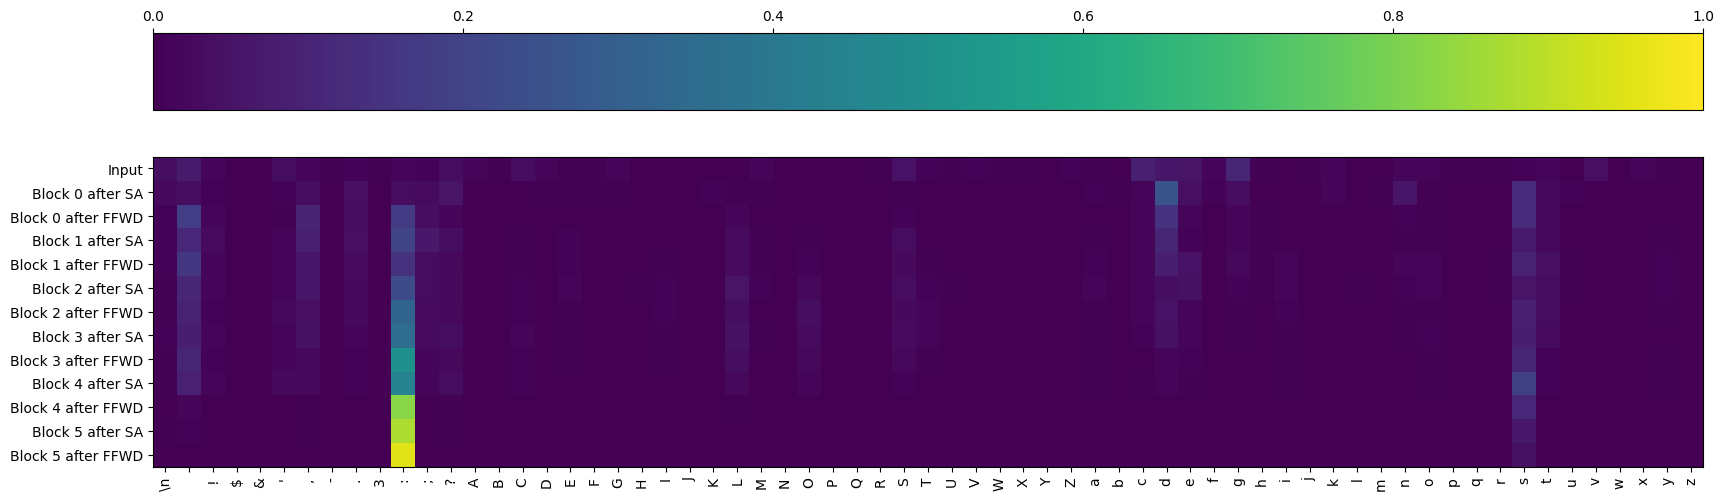

In [ ]:
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt='Citizen')
bia.plot()

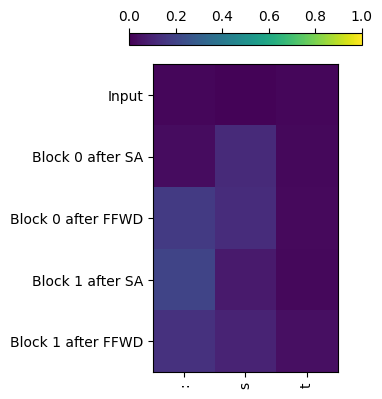

In [ ]:
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt='Citizen')
bia.plot_subset(rows=[0, 1, 2, 3, 4], cols=[tokenizer.stoi[c] for c in ':st'])

In [ ]:
# Sanity check for BlockInternalsAnalysis

# Run a prompt through the real model
prompt = 'Citizen'

tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
lw = LogitsWrapper(logits, tokenizer)

# Run the same prompt through the analysis
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt)

# The probabilities from the logits that came out of the model
# should be the same as the last row of data from the analysis.
test_close(lw.probs()[0, -1], bia.data[-1])

# Now run it through copied blocks we can look into
x = accessors.embed_tokens(tokens)
_, io_accessors = accessors.run_model(x)

# The probabilities from the embedded inputs should be the same as
# the first row of data from the analysis.
test_close(
    LogitsWrapper(accessors.logits_from_embedding(x), tokenizer).probs()[0, -1],
    bia.data[0],
)

# The rows containing the inputs for each block should match what the io_accessors
# say the inputs are.
for block_idx, io_accessor in enumerate(io_accessors):
    block_input = io_accessor.input('.')
    lw = LogitsWrapper(accessors.logits_from_embedding(block_input), tokenizer)
    test_close(lw.probs()[0, -1], bia.data[bia.idx_input_probs(block_idx)])

# The rows containing the ffwd adjustments for each block should be the same
# as the outputs from the blocks.
for block_idx, io_accessor in enumerate(io_accessors):
    block_output = io_accessor.output('.')
    lw = LogitsWrapper(accessors.logits_from_embedding(block_output), tokenizer)
    test_close(lw.probs()[0, -1], bia.data[bia.idx_ffwd_probs(block_idx)])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()